<a href="https://colab.research.google.com/github/AyeshTariq/Semantic-Segmentation-of-Rooftops/blob/main/Semantic%20Segmentation%20of%20Roofs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Semantic Segmentation of Roofs from Aerial Imagery using Deep Learning**

---
Presented by: Ayesha Tariq (565371), Elaheh Torabidashti (565388)

Submitted to: Dr. Prof. Christian Knoth

MSc. Geospatial Technologies: 2024-26


---

The first step in this semantic segmentation workflow is to bring in the aerial imagery dataset. We have used **"Aerial Imagery for Roof Segmentation"** from the Kaggle.

Since the notebook is in Google Colab, so we used the kagglehub library, which provides a simple interface to download Kaggle datasets directly.

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
atilol_aerialimageryforroofsegmentation_path = kagglehub.dataset_download('atilol/aerialimageryforroofsegmentation')

print('Data source import complete.')


100%|██████████| 17.4G/17.4G [02:53<00:00, 108MB/s]

Extracting files...


Data source import complete.


We imported all required libraries. These include tools for image processing, file handling, arrays, deep learning, and plotting. The dataset path is assigned using the value from the previous cell. The image size is fixed at 128×128 pixels. A function is created to load and process all images and masks. It reads `.tif` image files and filters out any mask files ending with `_vis.tif`. These `_vis` files are just visual overlays and not actual labels. The images and masks are resized and normalized to values between 0 and 1. The masks are also reshaped to add a single channel. The function is then used to load training, validation, and test data from their respective folders. Finally, the shapes of all loaded arrays are printed to confirm that everything is processed correctly.

In [ ]:
import os
import cv2
import globhttps://www.kaggle.com/api/v1/datasets/download/atilol/aerialimageryforroofsegmentation?dataset_version_number=9
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

# Define the dataset path (update this to your actual variable or string path)
dataset_path = atilol_aerialimageryforroofsegmentation_path  # Make sure this is defined correctly
IMG_SIZE = (128, 128)

def load_all_images(img_folder, mask_folder, img_size=IMG_SIZE):
    images, masks = [], []

    # Load all image files normally
    img_files = sorted(glob.glob(os.path.join(img_folder, "*.tif")))

    # Load only label files that DO NOT end with _vis.tif
    all_mask_files = sorted(glob.glob(os.path.join(mask_folder, "*.tif")))
    mask_files = [f for f in all_mask_files if not f.endswith("_vis.tif")]

    # Optional: Make sure both lists are the same length
    assert len(img_files) == len(mask_files), "Mismatch between images and non-_vis masks"

    for img_path, mask_path in zip(img_files, mask_files):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, img_size) / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size) / 255.0
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

Table of contents

[ ]

Start coding or generate with AI.

[1]
6m
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
atilol_aerialimageryforroofsegmentation_path = kagglehub.dataset_download('atilol/aerialimageryforroofsegmentation')

print('Data source import complete.')

Downloading from https://www.kaggle.com/api/v1/datasets/download/atilol/aerialimageryforroofsegmentation?dataset_version_number=9...
100%|██████████| 17.4G/17.4G [02:53<00:00, 108MB/s]Extracting files...

Data source import complete.

[2]
32m

# Load all training, validation, and test data
X_train, Y_train = load_all_images(f"{dataset_path}/train/image", f"{dataset_path}/train/label")
X_val, Y_val = load_all_images(f"{dataset_path}/val/image", f"{dataset_path}/val/label")
X_test, Y_test = load_all_images(f"{dataset_path}/test/image", f"{dataset_path}/test/label")

# Print shape of loaded datasets
print(f"Train: {X_train.shape}, {Y_train.shape}")
print(f"Val: {X_val.shape}, {Y_val.shape}")
print(f"Test: {X_test.shape}, {Y_test.shape}")


Train: (857, 128, 128, 3), (857, 128, 128, 1)
Val: (94, 128, 128, 3), (94, 128, 128, 1)
Test: (95, 128, 128, 3), (95, 128, 128, 1)


A U-Net model is defined for semantic segmentation. The input size is set to 128×128 pixels with 3 channels for RGB images.

The model has three main parts: **an encoder, a bottleneck, and a decoder**. The encoder extracts features using convolutional layers followed by max pooling to reduce the size. The bottleneck captures deep features in a compressed form. The decoder then upsamples the features to bring them back to the original size. Each upsampling step is followed by convolutional layers to refine the features. The final output layer uses a sigmoid activation to produce a binary mask for roof segmentation.

After defining the model, it is compiled using the Adam optimizer and binary cross-entropy loss. Accuracy is used as the evaluation metric. Finally, the model summary is printed to show the layer structure and number of parameters.

In [ ]:
def unet_model(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    c5 = Conv2D(256, (3, 3), activation="relu", padding="same")(u5)
    c5 = Conv2D(256, (3, 3), activation="relu", padding="same")(c5)

    u6 = UpSampling2D((2, 2))(c5)
    c6 = Conv2D(128, (3, 3), activation="relu", padding="same")(u6)
    c6 = Conv2D(128, (3, 3), activation="relu", padding="same")(c6)

    u7 = UpSampling2D((2, 2))(c6)
    c7 = Conv2D(64, (3, 3), activation="relu", padding="same")(u7)
    c7 = Conv2D(64, (3, 3), activation="relu", padding="same")(c7)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c7)

    model = keras.Model(inputs, outputs)
    return model

# Compile U-Net Model
model = unet_model()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Display Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 1)    │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,008,769 (26.74 MB)

 Trainable params: 7,008,769 (26.74 MB)

 Non-trainable params: 0 (0.00 B)

The training settings for the U-Net model are defined. The batch size is set to 16, which controls the amount of images the model processes before updating its weights. This size can be adjusted based on the available hardware memory. The model is set to train for 40 epochs, meaning it will go through the entire training dataset 40 times to learn patterns. The model is then trained using the training images and masks, while also validating its performance on the validation set after each epoch. The training progress is displayed with detailed output during the process.

In [ ]:
# Define training parameters
batch_size = 16  # Adjust based on available GPU/CPU memory
epochs = 40      # Increase if training time allows

# Train U-Net on the full dataset
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 972s 18s/step - accuracy: 0.8472 - loss: 0.1206 - val_accuracy: 0.9301 - val_loss: 0.0026
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 990s 18s/step - accuracy: 0.9258 - loss: 0.0026 - val_accuracy: 0.9301 - val_loss: 0.0023
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 946s 18s/step - accuracy: 0.9218 - loss: 0.0026 - val_accuracy: 0.9301 - val_loss: 0.0023
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 959s 18s/step - accuracy: 0.9283 - loss: 0.0023 - val_accuracy: 0.9301 - val_loss: 0.0023
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 983s 18s/step - accuracy: 0.9200 - loss: 0.0026 - val_accuracy: 0.9301 - val_loss: 0.0022
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 970s 18s/step - accuracy: 0.9202 - loss: 0.0026 - val_accuracy: 0.9301 - val_loss: 0.0022
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 993s 18s/step - accuracy: 0.9213 - loss: 0.0025 - val_accuracy: 0.9301 - val_loss: 0.0022
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 984s 18s/step - accuracy: 0.9167 - loss: 0.0027 - val_accuracy: 0.

To visualize the model’s predictions a function is created . It shows how well the U-Net model segments roofs. It takes test images, and ground truth masks as input. It predicts masks for the first few test images, with the default set to 10 samples.

For each sample, three images are displayed: the original aerial image, the true roof mask, and the predicted mask. All images are arranged in rows for easy comparison. The function uses Matplotlib to create a clean and organized layout for visual inspection of the model’s performance.

In [ ]:
def display_predictions(model, X_test, Y_test, num_samples=10):
    preds = model.predict(X_test[:num_samples])

    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(X_test[i])
        plt.title("Original")
        plt.axis("off")

        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(Y_test[i].squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
        plt.imshow(preds[i].squeeze(), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


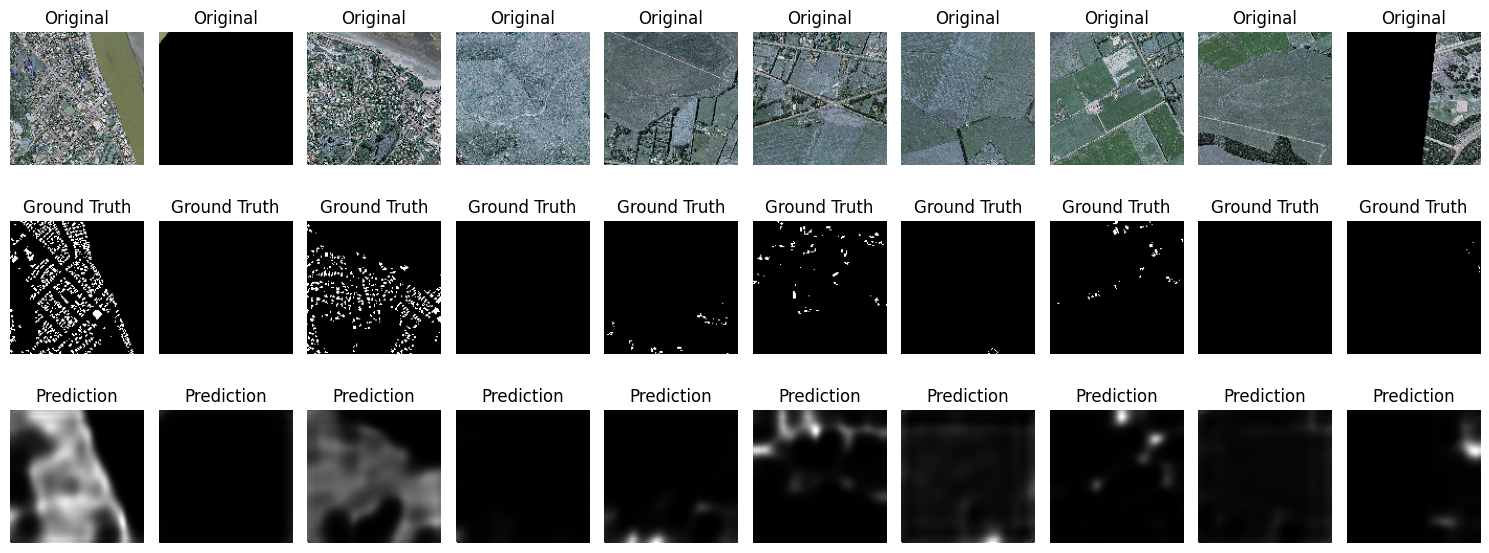

In [ ]:
display_predictions(model, X_test, Y_test, num_samples=10)

**Conclusion**

The results of the model were not as expected. Although the training and validation accuracy appeared high—92.78% and 93.01% respectively—the predicted masks were blurry and unclear.

This suggests that the model struggled to detect rooftops accurately. One key issue was class imbalance in the dataset. Most of the image area is background (black), while rooftops (white) occupy only a small portion. As a result, the model learned to focus more on the background, which inflated the accuracy but reduced its ability to segment rooftops effectively. The predictions often missed rooftops or showed them as faint, especially when they were small or unclear in the ground truth. Several factors likely contributed to this outcome. Resizing the images to 128×128 may have removed important rooftop details. The imbalance in class distribution encouraged the model to favor background predictions. Additionally, some ground truth masks were inaccurate or incomplete, which could have confused the model during training. Despite of these challenges our model was still able to predict at an adequate level of detecting rooftops.  

To improve performance, future work should use higher-resolution images, apply balancing techniques such as loss weighting or focused sampling, and ensure better label quality. It may also help to try more advanced segmentation models like U-Net++ or DeepLabV3+. Overall, while the model performed well numerically, visual inspection revealed that it still needs improvement in accurately identifying rooftops.